In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit import transpile, assemble, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from sympy import Matrix
import matplotlib.pyplot as plt
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.quantumcircuitdata import QuantumCircuitData, CircuitInstruction
from qiskit.circuit.classicalregister import ClassicalRegister, Clbit
from qiskit.circuit.quantumregister import QuantumRegister, Qubit
from qiskit.circuit.library.standard_gates.h import *
import qiskit
import numpy as np

from circuit_remapper import *
from components.inlin_layer import *

import warnings

warnings.filterwarnings("ignore")

C:\Users\anura\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\anura\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


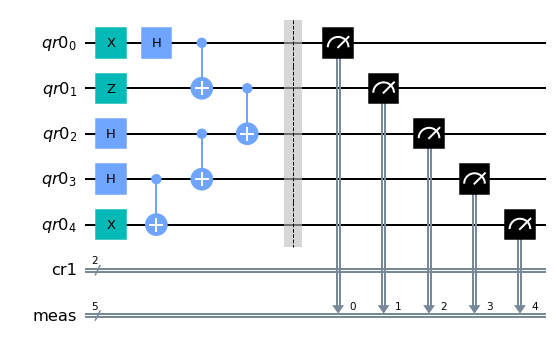

In [3]:
qc = QuantumCircuit(QuantumRegister(5, 'qr0'), ClassicalRegister(2, 'cr1'))
qc.x(0)
qc.h(0)
qc.z(1)
qc.cx(0, 1)
qc.x(4)
qc.h(3)
# qc.barrier()
qc.h(2)
qc.cx(3, 4)
qc.cx(2, 3)
qc.cx(1, 2)
qc.measure_all()
qc.draw(output='mpl')

In [4]:
circ_object = CircuitRemapper(qc, "hi")
layers_here = circ_object._circuit_to_layers()
layers_here

[[CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='z', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 1),), clbits=()),
  CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 4),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 3),), clbits=()),
  CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2),), clbits=()),
  CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0), Qubit(QuantumRegister(5, 'qr0'), 1), Qubit(QuantumRegister(5, 'qr0'), 2), Qubit(QuantumRegister(

In [5]:
Qubit_list = [Qubit(QuantumRegister(5, 'qr0'), i) for i in range(5)]
Cbit_list = [Clbit(ClassicalRegister(5, 'hola'), i) for i in range(5)]

layers_here += layers_here
qc_recons = circ_object._layer_to_circuit(layers_here, qubits=Qubit_list, clbits=Cbit_list)
qc_recons.draw()

┌───┐ ░ ┌───┐          ┌─┐┌───┐              ░ ┌───┐          ┌─┐      
 qr0_0: ┤ X ├─░─┤ H ├──■───────┤M├┤ X ├──────────────░─┤ H ├──■───────┤M├──────
        ├───┤ ░ └───┘┌─┴─┐     └╥┘└───┘┌─┐┌───┐      ░ └───┘┌─┴─┐     └╥┘┌─┐   
 qr0_1: ┤ Z ├─░──────┤ X ├──■───╫──────┤M├┤ Z ├──────░──────┤ X ├──■───╫─┤M├───
        ├───┤ ░      └───┘┌─┴─┐ ║      └╥┘└┬─┬┘┌───┐ ░      └───┘┌─┴─┐ ║ └╥┘┌─┐
 qr0_2: ┤ H ├─░────────■──┤ X ├─╫───────╫──┤M├─┤ H ├─░────────■──┤ X ├─╫──╫─┤M├
        ├───┤ ░      ┌─┴─┐└┬─┬┘ ║ ┌───┐ ║  └╥┘ └───┘ ░      ┌─┴─┐└┬─┬┘ ║  ║ └╥┘
 qr0_3: ┤ H ├─░───■──┤ X ├─┤M├──╫─┤ H ├─╫───╫────────░───■──┤ X ├─┤M├──╫──╫──╫─
        ├───┤ ░ ┌─┴─┐└┬─┬┘ └╥┘  ║ ├───┤ ║   ║        ░ ┌─┴─┐└┬─┬┘ └╥┘  ║  ║  ║ 
 qr0_4: ┤ X ├─░─┤ X ├─┤M├───╫───╫─┤ X ├─╫───╫────────░─┤ X ├─┤M├───╫───╫──╫──╫─
        └───┘ ░ └───┘ └╥┘   ║   ║ └───┘ ║   ║        ░ └───┘ └╥┘   ║   ║  ║  ║ 
hola: 5/═══════════════╬════╬═══╬═══════╬═══╬═════════════════╬════╬═══╬══╬══╬═
                       ║    ║   ║       ║   ║                 ║    ║   ║  ║  ║ 
meas: 5/═══════════════╩════╩═══╩═══════╩═══╩═════════════════╩════╩═══╩══╩══╩═
                       4    3   0       1   2                 4    3   0  1  2

In [6]:
a_layer = Layer(layers_here[4])
print(a_layer)

-CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0),), clbits=(Clbit(ClassicalRegister(5, 'meas'), 0),))-|
-CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 1),), clbits=(Clbit(ClassicalRegister(5, 'meas'), 1),))-|
-CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2),), clbits=(Clbit(ClassicalRegister(5, 'meas'), 2),))-|
-CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 3),), clbits=(Clbit(ClassicalRegister(5, 'meas'), 3),))-|
-CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 4),), clbits=(Clbit(ClassicalRegister(5, 'meas'), 4),))-|



In [90]:
def measure_sim(qc, samples=20000):
    backend = Aer.get_backend('qasm_simulator')
    circuit = transpile(qc, backend=backend)
    #     print(circuit)
    samples = 8192
    job = execute(qc, backend, shots=samples)
    counts = job.result().get_counts()
#     print("Job result: ", job.result())
    return counts

In [91]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
# print(qc)
qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

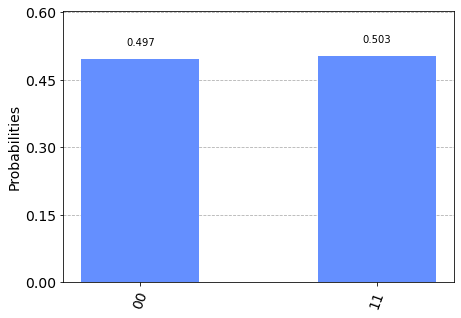

In [92]:
# run circuits on qasm simulator
sim_count = measure_sim(qc=qc)
plot_histogram(sim_count)  # Display the output on measurement of state vector

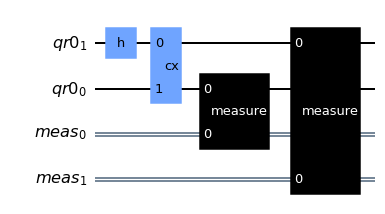

In [93]:
new_layer = [[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]),
                                 qubits=(Qubit(QuantumRegister(2, 'qr0'), 1),), clbits=())],
             [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
                                 qubits=(Qubit(QuantumRegister(2, 'qr0'), 1), Qubit(QuantumRegister(2, 'qr0'), 0)),
                                 clbits=())],
             [CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
                                 qubits=(Qubit(QuantumRegister(2, 'qr0'), 0),),
                                 clbits=(Clbit(ClassicalRegister(2, 'meas'), 0),)),
              CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
                                 qubits=(Qubit(QuantumRegister(2, 'qr0'), 1),),
                                 clbits=(Clbit(ClassicalRegister(2, 'meas'), 1),))]]

new_circ = circ_object._layer_to_circuit(new_layer)
# print(new_circ.data)
new_circ.draw(output='mpl')

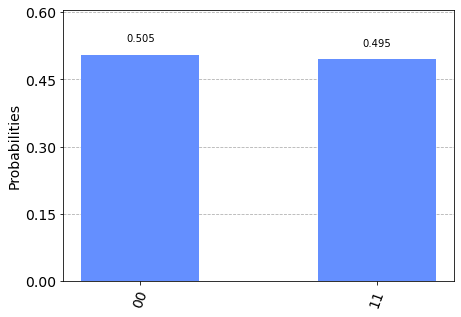

In [94]:
# run circuits on qasm simulator
sim_count = measure_sim(qc=new_circ)
plot_histogram(sim_count)  # Display the output on measurement of state vector

##### TEST for TOPOLOGY

In [95]:
# Write a q_map as dictionary 
qr0 = QuantumRegister(5, 'qr0')
q_map = {
    "QPU_1" : [Qubit(qr0, i) for i in range(3)],
    "QPU_2" : [Qubit(qr0, i) for i in range(3,5)]
}
q_map

{'QPU_1': [Qubit(QuantumRegister(5, 'qr0'), 0),
  Qubit(QuantumRegister(5, 'qr0'), 1),
  Qubit(QuantumRegister(5, 'qr0'), 2)],
 'QPU_2': [Qubit(QuantumRegister(5, 'qr0'), 3),
  Qubit(QuantumRegister(5, 'qr0'), 4)]}

###### Test for topology class methods

In [96]:
circuit_topo = Topology(q_map)

print("Total Number of Qubits in Topology : ", circuit_topo.num_qubits())
print("Total Number of QPUs in Topology: ", circuit_topo.num_hosts())

Qubit1 = q_map["QPU_1"][2]
Qubit2 = q_map["QPU_2"][1]
print("{} and {} are adjacent".format(Qubit1, Qubit2) 
      if circuit_topo.are_adjacent(Qubit1, Qubit2) else 
      "{} and {} are not adjacent".format(Qubit1, Qubit2))

for qubit in circuit_topo.qubits:
    print("Qubit: {} --------- Host: {}".format(qubit, circuit_topo.get_host(qubit)))

Total Number of Qubits in Topology :  5
Total Number of QPUs in Topology:  2
Qubit(QuantumRegister(5, 'qr0'), 2) and Qubit(QuantumRegister(5, 'qr0'), 4) are not adjacent
Qubit: Qubit(QuantumRegister(5, 'qr0'), 0) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(5, 'qr0'), 1) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(5, 'qr0'), 2) --------- Host: QPU_1
Qubit: Qubit(QuantumRegister(5, 'qr0'), 3) --------- Host: QPU_2
Qubit: Qubit(QuantumRegister(5, 'qr0'), 4) --------- Host: QPU_2


##### Test for Layer object defined in inlin_layer.py

In [97]:
qc = QuantumCircuit(qr0)
qc.h(0)
qc.cx(0,1)
qc.cx(2,0)
qc.cx(2,3)
qc.x(4)
qc.y(3)
qc.draw()

┌───┐     ┌───┐          
qr0_0: ┤ H ├──■──┤ X ├──────────
       └───┘┌─┴─┐└─┬─┘          
qr0_1: ─────┤ X ├──┼────────────
            └───┘  │            
qr0_2: ────────────■────■───────
                      ┌─┴─┐┌───┐
qr0_3: ───────────────┤ X ├┤ Y ├
       ┌───┐          └───┘└───┘
qr0_4: ┤ X ├────────────────────
       └───┘

In [98]:
circ_object = CircuitRemapper(qc, "hi")
layers_here = circ_object._circuit_to_layers()
layers_here

[[CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0),), clbits=()),
  CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 4),), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 0), Qubit(QuantumRegister(5, 'qr0'), 1)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2), Qubit(QuantumRegister(5, 'qr0'), 0)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2), Qubit(QuantumRegister(5, 'qr0'), 3)), clbits=())],
 [CircuitInstruction(operation=Instruction(name='y', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5,

In [99]:
a_layer = Layer(layers_here[3], circuit_topo)
print(a_layer)

-CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2), Qubit(QuantumRegister(5, 'qr0'), 3)), clbits=())-|



In [100]:
a_layer.non_local_operations()

[CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'qr0'), 2), Qubit(QuantumRegister(5, 'qr0'), 3)), clbits=())]

##### Cat Entangler

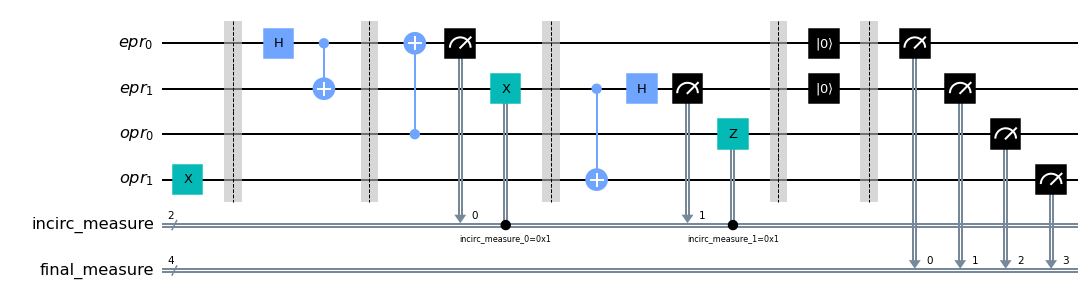

In [107]:
epr_qubits = QuantumRegister(2, "epr")
opr_qubits = QuantumRegister(2, "opr")
measure_bits = ClassicalRegister(2, "incirc_measure")
final_cbits = ClassicalRegister(4, "final_measure")
qc = QuantumCircuit(epr_qubits, opr_qubits, measure_bits, final_cbits)

#check for opr_1 = 1 and opr_2 = 1
# qc.x(2)
qc.x(3)
qc.barrier()

# Generate EPR pair
qc.h(0)
qc.cx(0, 1)
qc.barrier()
# cat entanglement
qc.cx(2,0)
qc.measure(0,0)
qc.x(1).c_if(measure_bits[0], 1)
qc.barrier()
qc.cx(1,3)
qc.h(1)
qc.measure(1,1)
qc.z(2).c_if(measure_bits[1], 1)
qc.barrier()
qc.reset(epr_qubits)

## Measurements
qc.barrier()
qc.measure(epr_qubits, final_cbits[0:2])
qc.measure(opr_qubits, final_cbits[2:4])

qc.draw(output='mpl')

{'1000 01': 2013, '1000 00': 2081, '1000 10': 2023, '1000 11': 2075}


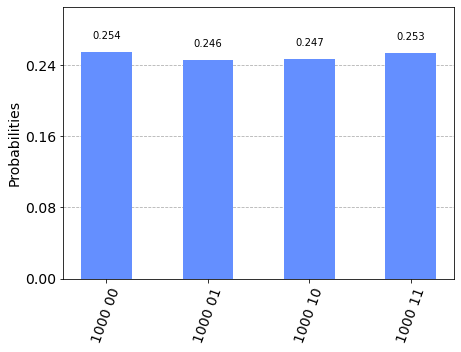

In [108]:
# run circuits on qasm simulator
sim_count = measure_sim(qc=qc)
print(sim_count)
plot_histogram(sim_count)  # Display the output on measurement of state vector

The cat entangling scheme works